In [1]:
from scipy.integrate import solve_ivp
from scipy.optimize import minimize
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

https://www.mdpi.com/1099-4300/25/3/497

https://www.sciencedirect.com/science/article/pii/S071734582300012X

https://pubmed.ncbi.nlm.nih.gov/34347510/

# Building the Monod Categorical Model

$$\begin{align*}
    \dot{Y} &= \mu_{\text{max}} \frac{S}{K_s + S}Y \\
    \dot{S} &= -\frac{1}{Y_{X/S}} \dot{Y} \\
    \dot{P} &= Y_{P/S} (-\dot{S})
\end{align*}$$

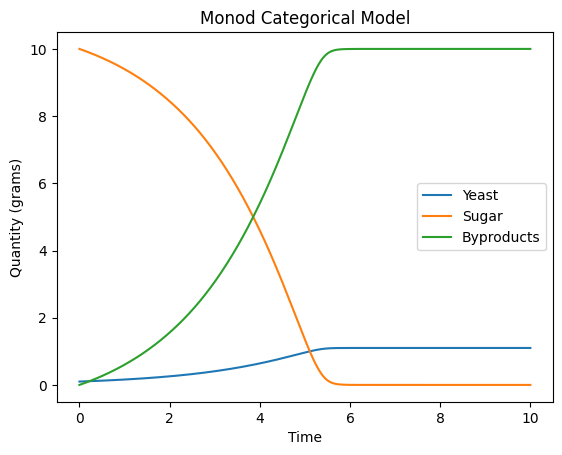

In [2]:
def ode(t, y, mu_max, K, Yxs, Yps):
    """Categorical model for yeast growth with three categories: yeast, sugar, and byproducts.
    Uses the monod equation for yeast growth.
    """
    return np.array([
        mu_max * (y[1] / (K + y[1])) * y[0],
        -(1 / Yxs) * mu_max * (y[1] / (K + y[1])) * y[0],
        (Yps / Yxs) * mu_max * (y[1] / (K + y[1])) * y[0]
    ])

# Building inputs
t0 = 0
tf = 10
t_span = (t0, tf)
y0 = np.array([0.1, 10, 0])  # g/L
t = np.linspace(t0, tf, 1000)

# Parameters
mu_max = 0.5  # Maximum growth rate of yeast
K = 0.6    # Half-velocity constant
Yxs = 0.1  # Biomass per g sugar
Yps = 1  # Product yield

sol = solve_ivp(ode, t_span, y0, t_eval=t,
                args=(mu_max, K, Yxs, Yps))

plt.plot(sol.t, sol.y[0], label="Yeast")
plt.plot(sol.t, sol.y[1], label="Sugar")
plt.plot(sol.t, sol.y[2], label="Byproducts")

plt.xlabel("Time")
plt.ylabel("Quantity (grams)")
plt.title("Monod Categorical Model")
plt.legend()

plt.show()

# KM Mechanistic Model

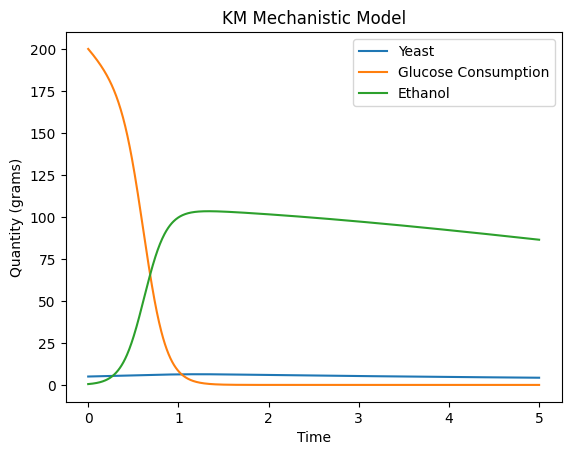

In [3]:
def ode(t, u, rho):
    """KM model from paper."""
    r1, r2, r3, r4, r5, r6, r7, r8, r9, r10 = rho
    x, y, z, = u
    return np.array([
        ((r1*x*y) / (r2+y)) - r3*x*z - r4*x,
        -r5*x*y - r6*y*z - r7*y,
        r8*x*z + r9*y*z - r10*z
    ])

# Building inputs
t0 = 0
tf = 5
t_span = (t0, tf)
u0 = np.array([5, 200, 0.5])  # g/L
t = np.linspace(t0, tf, 1000)

# Parameters
r1 = 289.385e-3
r2 = 2.281
r3 = 1.066e-3
r4 = 7.275e-3
r5 = 56.893e-3
r6 = 71.842e-3
r7 = 824.233e-9
r8 = 19.088e-3
r9 = 46.352e-3
r10 = 149.899e-3
rho = [r1, r2, r3, r4, r5, r6, r7, r8, r9, r10]

sol = solve_ivp(ode, t_span, u0, t_eval=t,
                args=(rho,))

plt.plot(sol.t, sol.y[0], label="Yeast")
plt.plot(sol.t, sol.y[1], label="Glucose Consumption")
plt.plot(sol.t, sol.y[2], label="Ethanol")

plt.xlabel("Time")
plt.ylabel("Quantity (grams)")
plt.title("KM Mechanistic Model")
plt.legend()

plt.show()

# Fitting the Monod Categorical Model to Real World Data

In [124]:
yeast = pd.read_csv("data/yeast_strain1.csv").values[:, 1]
sugar = pd.read_csv("data/sugar_strain1.csv").values[:, 1]
byprod = pd.read_csv("data/ethanol_strain1.csv").values[:, 1]
true_vals = np.vstack([yeast, sugar, byprod])

# Error function to fit parameters
def calculate_error(params):
    mu_max, K, Yxs, Yps = params

    def ode(t, y, mu_max, K, Yxs, Yps):
        """Categorical model for yeast growth with three categories: yeast, sugar, and byproducts.
        Uses the monod equation for yeast growth.
        """
        return np.array([
            mu_max * (y[1] / (K + y[1])) * y[0],
            -(1 / Yxs) * mu_max * (y[1] / (K + y[1])) * y[0],
            (Yps / Yxs) * mu_max * (y[1] / (K + y[1])) * y[0]
        ])
    
    t0 = 0
    tf = 13
    t_span = (t0, tf)
    t_eval = np.linspace(t0, tf, 14)
    y0 = np.array([yeast[0], sugar[0], byprod[0]])

    sol = solve_ivp(ode, t_span, y0, t_eval=t_eval, 
                    args=(mu_max, K, Yxs, Yps))

    return np.max(np.linalg.norm(sol.y - true_vals, axis=0))

# Initial guess for parameters
p0 = (0.1, 0.1, 0.2, 0.7)
result = minimize(calculate_error, p0)
mu_max, K, Yxs, Yps = result.x

In [125]:
mu_max, K, Yxs, Yps

(np.float64(0.16854337844269407),
 np.float64(0.099646466975818),
 np.float64(0.17679666821119774),
 np.float64(0.7015312374270101))

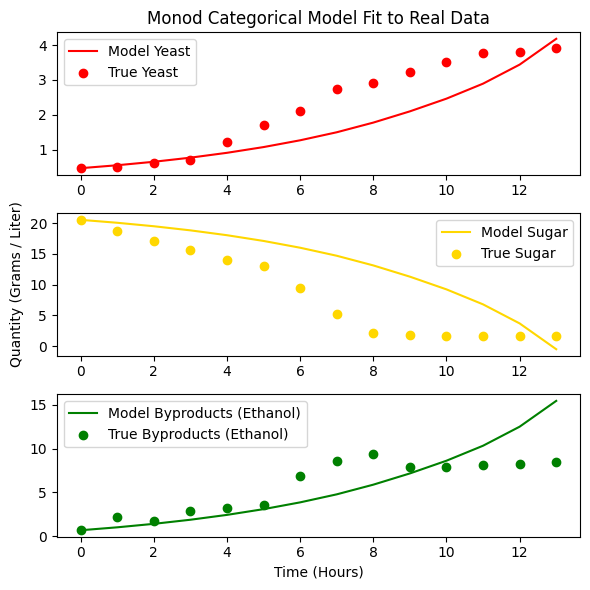

In [126]:
def ode(t, y, mu_max, K, Yxs, Yps):
    """Categorical model for yeast growth with three categories: yeast, sugar, and byproducts.
    Uses the monod equation for yeast growth.
    """
    return np.array([
        mu_max * (y[1] / (K + y[1])) * y[0],
        -(1 / Yxs) * mu_max * (y[1] / (K + y[1])) * y[0],
        (Yps / Yxs) * mu_max * (y[1] / (K + y[1])) * y[0]
    ])

t0 = 0
tf = 13
t_span = (t0, tf)
t_eval = np.linspace(t0, tf, 14)
y0 = np.array([yeast[0], sugar[0], byprod[0]])

sol = solve_ivp(ode, t_span, y0, t_eval=t_eval,
                args=(mu_max, K, Yxs, Yps))

plt.figure(figsize=(6, 6))
plt.subplot(3, 1, 1)
plt.plot(sol.t, sol.y[0], color='r', label="Model Yeast")
plt.scatter(t_eval, yeast, color='r', label="True Yeast")
plt.legend()
plt.title("Monod Categorical Model Fit to Real Data")

plt.subplot(3, 1, 2)
plt.plot(sol.t, sol.y[1], color='gold', label="Model Sugar")
plt.scatter(t_eval, sugar, color='gold', label="True Sugar")
plt.ylabel("Quantity (Grams / Liter)")
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(sol.t, sol.y[2], color='g', label="Model Byproducts (Ethanol)")
plt.scatter(t_eval, byprod, color='g', label="True Byproducts (Ethanol)")
plt.legend()
plt.xlabel("Time (Hours)")
plt.tight_layout()
plt.show()